# Machine Learning to detect pants

In this notebook, we will be training our pants model to use on predicitions and therefore, be able to detect the required pants

### Library Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import itertools

%matplotlib inline
from IPython.display import Image

# Libraries for TensorFlow
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.applications import resnet50
import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight


### Load data

Dataset extracted from: https://www.kaggle.com/agrigorev/clothing-dataset-full

In [2]:
originalCSV = pd.read_csv('Data/images.csv')
originalCSV.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [3]:
dataCSV = originalCSV
typeOfData = dataCSV["label"].value_counts()
typeOfData

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

## Data cleaning

Since most of the data has been categorized, and we are mostly interested on some of the labels, and not all, to simplify and improve the training process, we are going to remove some of the categories. And transform them into a single type. We will transform those labels into, Top, Shorts, Pants, and remove some

The label Top will contain:
T-Shirt
LongSleeve
Shirt

The label Bottom will contain:
Pants

The other Shorts will contain:
Shorts

The removed ones will be:
Skirt
Dress
OutWear
Hat
Blazer
Hoodie
Skip
Blouse
Top
Polo
Undershirt.

Also, all data regarding kids will be removed too

In [4]:
imagesPath = 'Data/images_compressed'
dataCSV['image'] = imagesPath + '/' + originalCSV['image'] +'.jpg' #We adjust the data so that it is well defined
dataCSV.dropna()

dataCSV.loc[dataCSV['label'] == 'T-Shirt','label'] = 'Top'
dataCSV.loc[dataCSV['label'] == 'LongSleeve','label'] = 'Top'
dataCSV.loc[dataCSV['label'] == 'Shirt','label'] = 'Top'

dataCSV.loc[dataCSV['label'] == 'Pants','label'] = 'Bottom_Long'

dataCSV.loc[dataCSV['label'] == 'Shorts','label'] = 'Bottom_Short'
kidsRemoved = dataCSV.loc[dataCSV["kids"] == "False"]

newColumns = ['Top','Bottom_Long', 'Bottom_Short']
finalData = dataCSV.loc[dataCSV["label"].str.contains("Top|Bottom_Long|Bottom_Short")]
data_df = finalData[['image', 'label']]

Now we can check our new data

In [5]:
typeOfData = data_df["label"].value_counts()
data_df.head()
typeOfData

Top             1432
Bottom_Long      692
Bottom_Short     308
Name: label, dtype: int64

## Loading Data

It is required to prepare the data to be used on our model. To do so, we will transform the existing paths of images, to the specific image

#### I need to take a look at asynchronous file loading 

In [6]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
EPOCHS = 20

#### This might need touch up since i don't thing the rescale is right, and that the labels are in the correct normalization

In [7]:
generator = image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)
train_set = generator.flow_from_dataframe(
    dataframe=data_df,
    x_col="image",
    y_col="label",
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_set = generator.flow_from_dataframe(
    dataframe=data_df,
    x_col="image",
    y_col="label",
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
num_classes = len(train_set.class_indices)
print("Total classes:", num_classes)

Found 1946 validated image filenames belonging to 3 classes.
Found 486 validated image filenames belonging to 3 classes.
Total classes: 3


It would be interesting to use a pretrained model so that the training process is slowed down, and potentially, we will get better results. To avoid retraining it, we can use a common model like resNet. Therefore we can make use of pythorch pretrained models. We will split the data into the test and train data set so that we can use it for our pretrained model

https://keras.io/api/layers/

In [8]:
input_layer = layers.Input(shape=(WIDTH,HEIGHT,3)) #We set the input layer to the data format we desire

resNet=resnet50.ResNet50(weights='imagenet', input_tensor=input_layer,include_top=False) #We get the resnet model
last_layer=resNet.output #We take output layers of resnet
flatten=layers.Flatten()(last_layer) # Add flatten layer: we are extending Neural Network by adding flattn layer

# Add dense layer to the final output layer
output_layer =layers.Dense(num_classes,activation='softmax')(flatten)

# Creating model with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)
model.summary()

for layer in model.layers[:-1]: #Freezing lower layers (in this case only lower layer)
    layer.trainable=False

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [9]:
checkpoint_path = "modelTraining/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Once the model is prepared we can train it

### Unbalanced Model

We will first try with an unbalanced weighting on the data

In [10]:
unbalancedModel = model
unbalancedModel.fit(train_set,epochs=EPOCHS,verbose=True,validation_data=val_set, callbacks=[cp_callback])

Epoch 1/20
61/61 [==============================] - ETA: 0s - loss: 1.8058 - accuracy: 0.6506
Epoch 1: saving model to modelTraining\cp.ckpt
61/61 [==============================] - 112s 2s/step - loss: 1.8058 - accuracy: 0.6506 - val_loss: 0.8430 - val_accuracy: 0.6626
Epoch 2/20
61/61 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.8222
Epoch 2: saving model to modelTraining\cp.ckpt
61/61 [==============================] - 110s 2s/step - loss: 0.4660 - accuracy: 0.8222 - val_loss: 0.8311 - val_accuracy: 0.6728
Epoch 3/20
61/61 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8592
Epoch 3: saving model to modelTraining\cp.ckpt
61/61 [==============================] - 110s 2s/step - loss: 0.3654 - accuracy: 0.8592 - val_loss: 0.6087 - val_accuracy: 0.7675
Epoch 4/20
61/61 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.8160
Epoch 4: saving model to modelTraining\cp.ckpt
61/61 [==============================] - 108s 

In [11]:
unbalancedModel.save('saved_model/pantsModel_unbalanced')

INFO:tensorflow:Assets written to: saved_model/pantsModel_unbalanced\assets


### Balanced Model

We will also train a blanaced Model, having some balanced weights to use

In [12]:
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(train_set.labels),y=train_set.labels)
class_weight_dict = {i : class_weights[i] for i in range(train_set.labels)}
print(class_weight_dict)

{0: 1.1666666666666667, 1: 2.857562408223201, 2: 0.5577529378045285}


In [13]:
balancedModel = model
balancedModel.fit(train_set,epochs=EPOCHS,verbose=True,validation_data=val_set, callbacks=[cp_callback], class_weight = class_weight_dict)

Epoch 1/20
61/61 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8859
Epoch 1: saving model to modelTraining\cp.ckpt
61/61 [==============================] - 103s 2s/step - loss: 0.3811 - accuracy: 0.8859 - val_loss: 1.6503 - val_accuracy: 0.5412
Epoch 2/20
61/61 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.8124
Epoch 2: saving model to modelTraining\cp.ckpt
61/61 [==============================] - 102s 2s/step - loss: 0.6096 - accuracy: 0.8124 - val_loss: 0.8637 - val_accuracy: 0.7840
Epoch 3/20
61/61 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.9018
Epoch 3: saving model to modelTraining\cp.ckpt
61/61 [==============================] - 102s 2s/step - loss: 0.2671 - accuracy: 0.9018 - val_loss: 0.8626 - val_accuracy: 0.7325
Epoch 4/20
61/61 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9388
Epoch 4: saving model to modelTraining\cp.ckpt
61/61 [==============================] - 102s 

In [14]:
balancedModel.save('saved_model/pantsModel_balanced')

INFO:tensorflow:Assets written to: saved_model/pantsModel_balanced\assets


## Observing results

In [15]:
"""
Function extracted from https://deeplizard.com/learn/video/km7pxKy4UHU to create a confusion matrix
"""
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Balanced Model

In [16]:
predictions = balancedModel.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
balancedModel.evaluate(train_set)

61/61 [==============================] - 89s 1s/step - loss: 0.0633 - accuracy: 0.9830


[0.06325993686914444, 0.9830421209335327]

Confusion matrix, without normalization
[[154  66 336]
 [ 79  24 124]
 [333 141 689]]


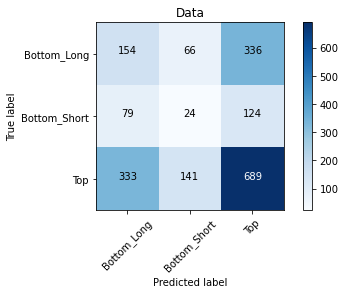

In [17]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Data')

## Unbalanced Model

In [18]:
predictions = unbalancedModel.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
unbalancedModel.evaluate(train_set)

61/61 [==============================] - 87s 1s/step - loss: 0.0633 - accuracy: 0.9830


[0.06325993686914444, 0.9830421209335327]

Confusion matrix, without normalization
[[155  66 335]
 [ 74  26 127]
 [337 139 687]]


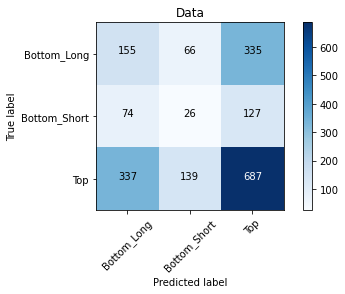

In [19]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Data')

References from 

https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18/notebook

https://www.kaggle.com/marissafernandes/clothes-image-classifier/notebook

https://www.kaggle.com/viratkothari/image-classification-transfer-learning-resnet50